The purpose of this project is to build an image recognition model that can detect a tomato plant and detect if it suffers from a number of diseases or if it is healthy.

Importation of modules to use during the development of the image recognition model.

In [1]:
#importation of modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## Preprocessing

Let's start by defining some variables to make the code easier to understand.

In [2]:
img_size = 256
batch_size = 32
channels = 3

The dataset will contain batches of images of a certain size. In this case, the database will contain batches of 32 images and each image will have 256x256 pixels.

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Tomato plant images',
    shuffle = True,
    image_size = (img_size, img_size),
    batch_size = batch_size
)

Found 16011 files belonging to 10 classes.


The dataset contains 16011 images categorised in nine different diseases and a healthy one.

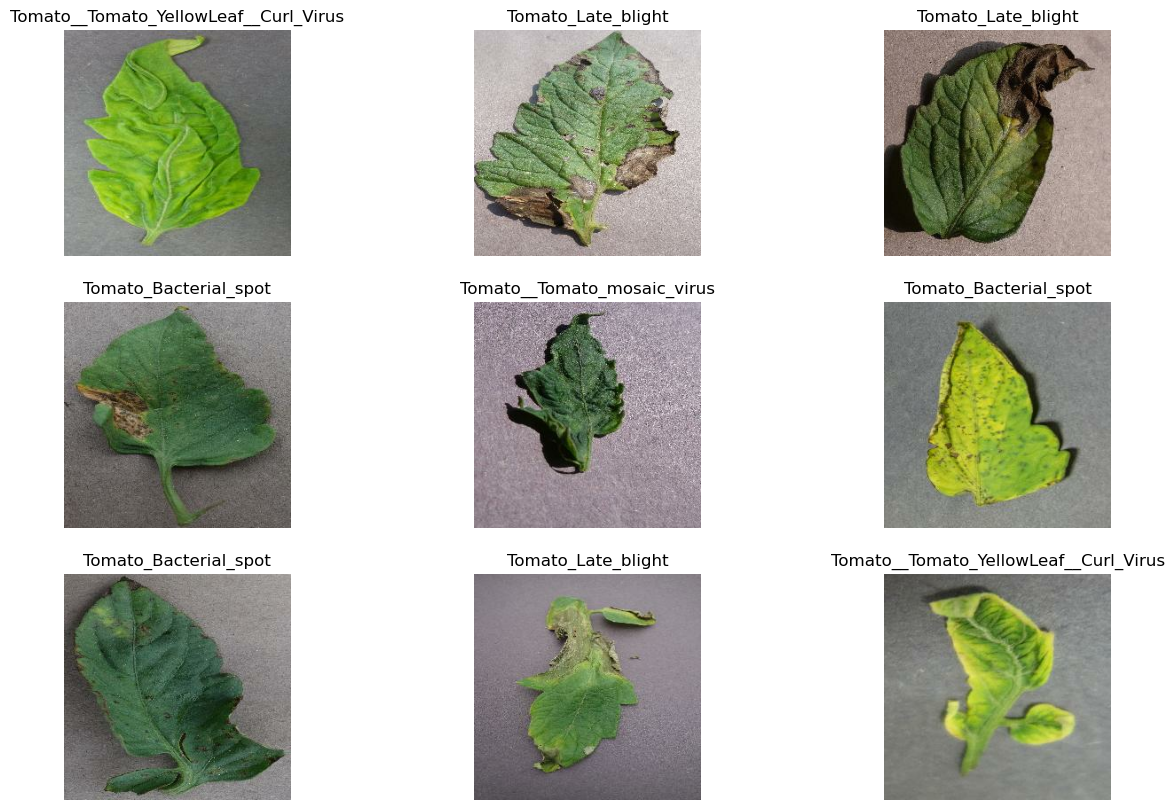

In [33]:
#visualization of images contained in the dataset.
plt.figure(figsize = (15, 10))
for img_batch, label_batch in dataset.take(1):
    for i in range(9):
        img_view = plt.subplot(3, 3, i + 1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')

Before starting to build the neural network of the model, it's useful to partition the dataset into three different ones. To do this, a function that will divide the entire dataset into 80% training, 10% validation and 10% testing is created.

In [5]:
def dataset_partitions(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 1000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 10)
        
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

Manipulation of the datasets created previously to improve the efficiency and performance of the model. '.cache()' will keep every image in the memory once it is read (making the time to read it again shorter) and 'prefecht' will read the next batch of images (while the model is training the previous batch).

In [6]:
train_dataset, val_dataset, test_dataset = dataset_partitions(dataset)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Creation of layers to generate more images from the original ones, feeding the model with more different types of images it can train with.

In [7]:
#function to resize and rescale the images in dataset
resizing_and_rescaling = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0/255.0)
])

In [8]:
#function to create more images from the original
dataset_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

## Model Building and Training

The model will consist of a neural network comprised of different layers that will analyse every image from the batch - pixel by pixel - and classify it into one of the ten categories.

In [9]:
number_classes = len(dataset.class_names)
recon_model = models.Sequential([
    resizing_and_rescaling,
    dataset_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (batch_size, img_size, img_size, channels)),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'), 
    layers.MaxPooling2D((2, 2)),  
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(number_classes, activation = 'softmax')   
])

recon_model.build(input_shape = (batch_size, img_size, img_size, channels))

C:\Users\Tino\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Below is the structure of the neural network composing the model.

In [10]:
recon_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

Model compilation to introduce an optimiser ('adam' is one of the most famous ones), a loss function, and the accuracy metric to track the performance of the model during the training process.

In [11]:
recon_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

Below is the training and validation process of the model.

In [12]:
model_history = recon_model.fit(
    train_dataset,
    epochs = 10,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.2744 - loss: 1.9759 - val_accuracy: 0.4856 - val_loss: 1.4675
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 387s 965ms/step - accuracy: 0.5464 - loss: 1.3084 - val_accuracy: 0.6000 - val_loss: 1.1007
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 372s 930ms/step - accuracy: 0.7071 - loss: 0.8446 - val_accuracy: 0.7500 - val_loss: 0.7322
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 366s 916ms/step - accuracy: 0.7822 - loss: 0.6264 - val_accuracy: 0.7412 - val_loss: 0.6952
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 358s 894ms/step - accuracy: 0.8081 - loss: 0.5413 - val_accuracy: 0.8244 - val_loss: 0.5003
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 367s 917ms/step - accuracy: 0.8470 - loss: 0.4284 - val_accuracy: 0.7869 - val_loss: 0.6206
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 368s 920ms/step - accuracy: 0.8610 - loss: 0.3908 - val_accuracy: 0.8037 - val_loss: 0.5580
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 361s 903ms/step - accuracy: 0.8784 - lo

In [13]:
#evaluation of the model with test dataset
model_scores = recon_model.evaluate(test_dataset)

51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 311ms/step - accuracy: 0.8837 - loss: 0.3761


The graphics below show that the more epochs are added to the model, the more accuracy increases and losses decrease. It's important to note that this does not mean that a really large number of epochs would improve the model exponentially, because the graphs show a clear logarithmic tendency.

Text(0.5, 1.0, 'Training & validation loss')

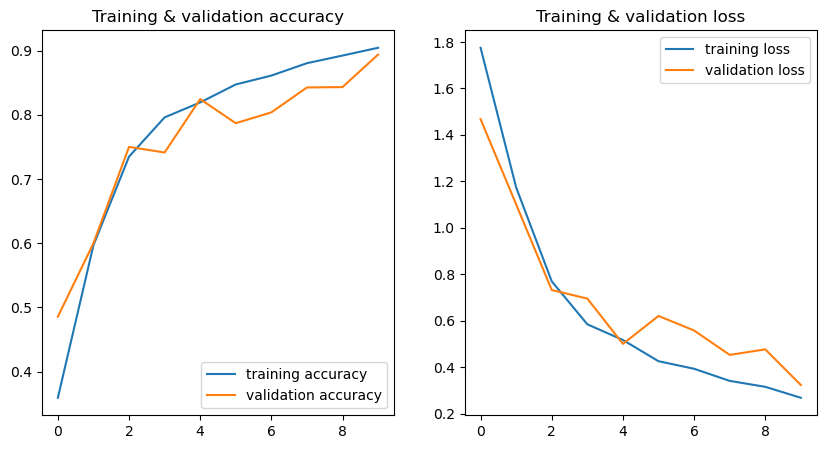

In [37]:
#accuracy and loss visualization of training and validation processes.
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), train_accuracy, label = 'training accuracy')
plt.plot(range(10), val_accuracy, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), train_loss, label = 'training loss')
plt.plot(range(10), val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training & validation loss')

## Model Predictions

Once the model is trained, validated and tested, it's time to make some predictions with it. In this case, the batches from the test dataset will be used as we do not have any more images of tomato plants. The images will be passed onto the model as a numpy array because it has been trained with groups of images rather than single ones.

In [20]:
#function to predict any batch of images given to the model
def recon_model_predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)
    model_prediction = recon_model.predict(image_array)
    predicted_class = dataset.class_names[np.argmax(model_prediction[0])]
    prediction_confidence = round(100 * (np.max(model_prediction[0])), 2)
    return predicted_class, prediction_confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


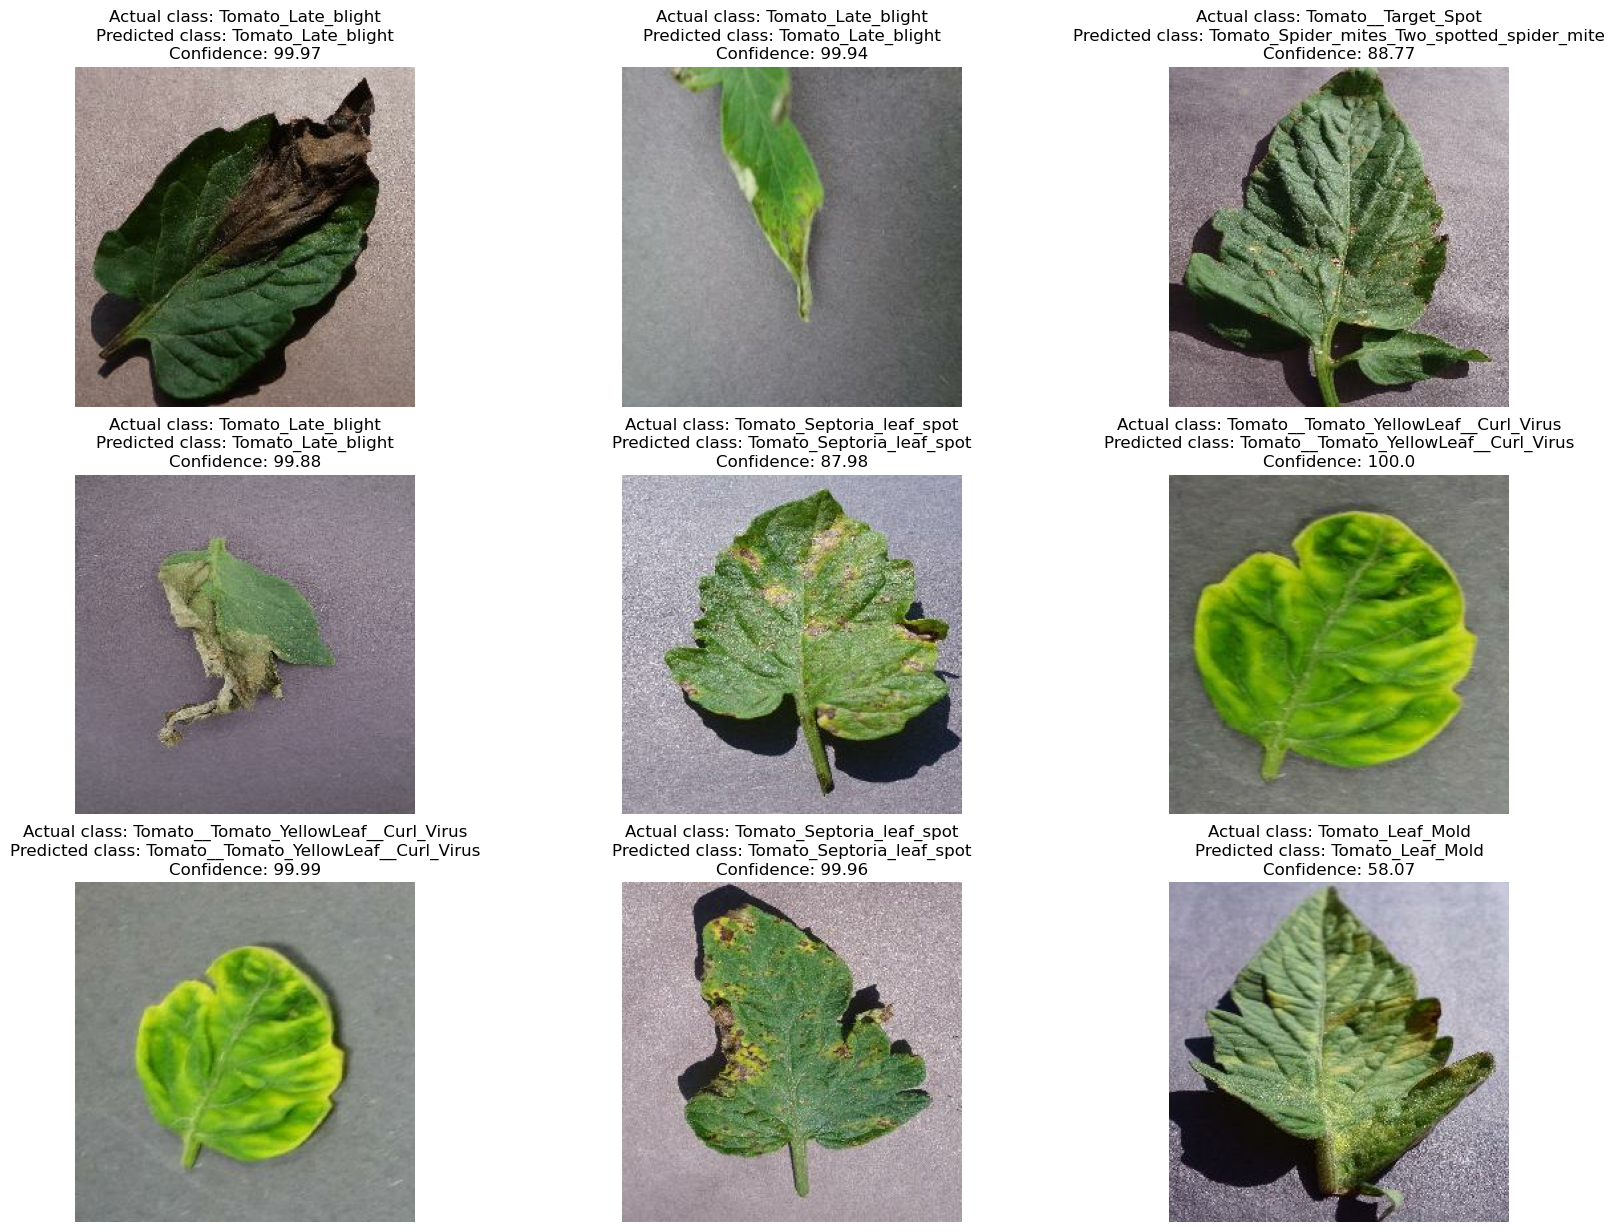

In [32]:
#visualization of the model predictions
plt.figure(figsize = (20, 15))

for images, labels in test_dataset.take(1):
    for i in range(9):
        subplots = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, prediction_confidence = recon_model_predict(recon_model, images[i].numpy())
        actual_class = dataset.class_names[labels[i]]
        plt.title('Actual class: {0}\nPredicted class: {1}\nConfidence: {2}'.format(actual_class, predicted_class, prediction_confidence))
        plt.axis('off')